# Post-hoc statistics about generated results

## Imports

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px


from paths import bsc_path, word_plot_res_path, word_plot_info_path, word_cluster_dbscan_plot_path, word_cluster_kmeans_plot_path
from reshandler import EncoderResHandler, ClusterHandler
from measurements import *
from my_utils import remove_starting_space

## 1. Direction Consistency

In [2]:
vars = []
reshandler = EncoderResHandler(data_dir=word_plot_res_path, info_dir=word_plot_info_path)

for datapath in os.listdir(word_plot_res_path): 
    reshandler.file_prefix = datapath.split(".")[0]
    reshandler.read()
    res = reshandler.data

    angles, var = DirectionalConsistency.analyze(res)
    vars.append(var)

In [3]:
np.mean(vars)

0.573041228383216

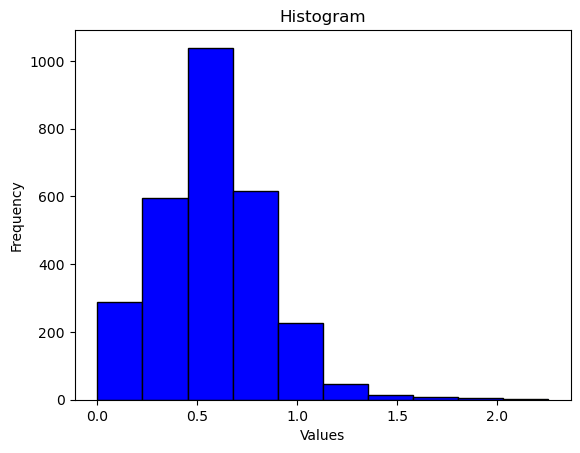

In [4]:
# Create a histogram
plt.hist(vars, bins=10, color='blue', edgecolor='black')

# Customize the plot (optional)
plt.title('Histogram')
plt.xlabel('Values')
plt.ylabel('Frequency')

# Display the histogram
plt.show()


## 2. Clustering

### DBSCAN
- Note that this part is non-fix number clustering, meaning that the total number of clusters is not fixed for the dataset. However, we could see that, when we find a configuration that produces in general comparable number of clusters as the number of segments in reality, the degree of matching is quite high, i.e. for most words the clustering algorithm has found out the correct number of clusters (therefore diff = 0), or if mistaken, the algorithm has one more cluster, which is basically matching the ground truth that we have.  

#### Looking for a good eps & min_samples using massive trials

In [5]:
num_clusters_list = []

for i in range(2000): 
    # Load your data (replace this with your own data)
    data = np.random.rand(20, 3)  # Example random data with shape (frame_num, 3)

    _, num_clusters = Clusterer.dbscan(data=data, r=0.36, m=1)

    num_clusters_list.append(num_clusters)
    
np.mean(num_clusters_list)

4.9695

#### Looping over the data

In [6]:
num_segments_list = []
num_clusters_list = []

file_prefixes = []
infos = []
labelss = []
ress = []

In [7]:
reshandler = EncoderResHandler(data_dir=word_plot_res_path, info_dir=word_plot_info_path)

for datapath in os.listdir(word_plot_res_path): 
    reshandler.file_prefix = datapath.split(".")[0]
    reshandler.read()

    res = reshandler.data
    info = reshandler.info

    labels, num_clusters = Clusterer.dbscan(res, r=0.3, m=1)

    num_segments_list.append(len(remove_starting_space(info[1]).split(" ")))
    num_clusters_list.append(num_clusters)

    file_prefixes.append(reshandler.file_prefix)
    infos.append(info)
    ress.append(res)
    labelss.append(labels)

In [8]:
np.mean(num_segments_list), np.mean(num_clusters_list)

(2.954929577464789, 2.887323943661972)

In [9]:
# Create a DataFrame
df = pd.DataFrame({'Segments': num_segments_list, 'Clusters': num_clusters_list})

# Add a new column for the difference
df['Difference'] = df['Segments'] - df['Clusters']

df

,Segments,Clusters,Difference
0,2,3,-1
1,7,1,6
2,1,2,-1
3,3,4,-1
4,4,2,2
...,...,...,...
2835,4,2,2
2836,3,2,1
2837,2,3,-1
2838,1,4,-3


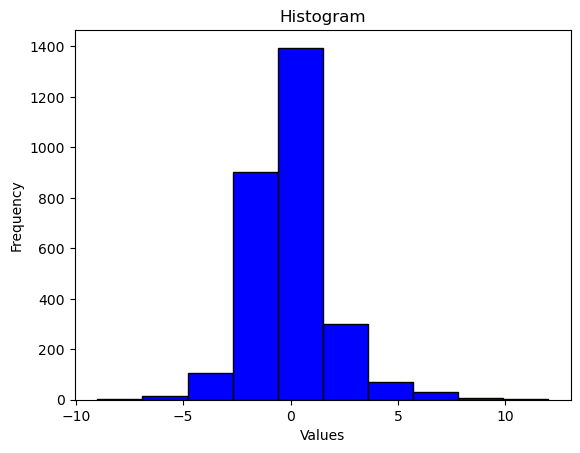

In [10]:
# Create a histogram
plt.hist(df['Difference'].tolist(), bins=10, color='blue', edgecolor='black')

# Customize the plot (optional)
plt.title('Histogram')
plt.xlabel('Values')
plt.ylabel('Frequency')

# Display the histogram
plt.show()

#### Save results

In [11]:
clhandler = ClusterHandler(put_path=os.path.join(bsc_path, "dbscan.intgrt"), 
                           data=(file_prefixes, infos, ress, labelss))
# file prefix, info, ress, preds
clhandler.save()

#### Plot the Clusters

In [12]:
def oneOut2ProgFrame(oneOut): 
    # oneOut is of tensor of shape (L, D)
    cols = ["dim_0", "dim_1", "dim_2", "cluster"]
    df = pd.DataFrame(oneOut, columns=cols)
    df["timestep"] = df.index
    df = df[["timestep"] + cols]
    return df
def minmax(arr, a=-1, b=1): 
    min = arr.min()
    max = arr.max()
    return (b - a) * ((arr - min) / (max - min)) + a
def operate_on(arr): 
    # return minmax(arr)
    return arr
def framify(these_hids): 
    # these are token categories to be included
    # these hids are the corresponding hids
    # these numtags are the corresponding tags, named using indices in these
    # these_hids = st.zscore(these_hids, axis=0)
    df = pd.DataFrame(data=these_hids)
    # df = df.rename(columns={0: "dim_0", 1: "dim_1", 2: "dim_2"})
    df['dim_0_norm'] = operate_on(df['dim_0'])
    df['dim_1_norm'] = operate_on(df['dim_1'])
    df['dim_2_norm'] = operate_on(df['dim_2'])
    return df

def plot3dtrajectory(X): 
    config = {
    'toImageButtonOptions': {
        'format': 'png', # one of png, svg, jpeg, webp
        'filename': 'custom_image',
        'height': 1280,
        'width': 1280,
        'scale': 1 # Multiply title/legend/axis/canvas sizes by this factor
    }
    }

    fig = px.line_3d(framify(X), x="dim_0_norm", y="dim_1_norm", z="dim_2_norm", 
                     hover_data=["timestep"], color="cluster", markers=True)
    fig.update_traces(marker=dict(size=2, color="red"))
    fig.update_layout(
        scene = dict(
            xaxis = dict(nticks=8, range=[-1,1],),
                        yaxis = dict(nticks=8, range=[-1,1],),
                        zaxis = dict(nticks=8, range=[-1,1],),),)
    # fig.update_layout(legend= {'itemsizing': 'constant'})
    # fig.update_layout(legend_title_text='Phone')
    fig.update_layout(
        legend=dict(
            x=0,
            y=1,
            title_font_family="Times New Roman",
            font=dict(
                family="Times New Roman",
                size=36,
                color="black"
            ),
            # bgcolor="LightSteelBlue",
            bordercolor="Black",
            borderwidth=1
        )
    )
    fig.update_layout(
        margin=dict(l=0, r=0, t=0, b=0),
    )
    camera = dict(
        eye=dict(x=0., y=0., z=2.5)
    )
    fig.update_layout(scene_camera=camera)
    html_plot = fig.to_html(full_html=False, config=config)
    # fig.show(config=config)
    return html_plot

def save_html(htmlplot, plot_path, file_name, info_token, info_produce_segs): 
    save_html_path = os.path.join(plot_path, "{}.html".format(file_name))
    with open(save_html_path, "w") as f: 
        f.write('<meta charset="UTF-8">')
        f.write("<h3>Token: {}</h3>".format(info_token))
        f.write("<h3>Produced Segments: {}</h3>".format(info_produce_segs))
        f.write("<hr>")
        f.write(htmlplot)

In [13]:
for idx in range(len(file_prefixes)): 
    file_name = file_prefixes[idx]
    info_token, info_produce_segs = infos[idx]
    res = ress[idx]
    labels = labelss[idx]

    # Convert the list to a NumPy array with shape (frame_num, 1)
    labels_array = np.array(labels).reshape(-1, 1)

    # Combine the arrays horizontally (horizontally stack them)
    combined_array = np.hstack((res, labels_array))

    res_df = oneOut2ProgFrame(combined_array) # one in batch
    res_df = framify(res_df)
    htmlplot = plot3dtrajectory(res_df)
    save_html(htmlplot=htmlplot, 
              plot_path=word_cluster_dbscan_plot_path, 
              file_name=file_name, 
              info_token=info_token, info_produce_segs=info_produce_segs)

### Kmeans++
使用kmeans我们需要为每一次clustering传入一个number of clusters的参数，因此我们也得以控制每一个clustering结果中聚类的数量，这样我们就可以把每一个聚类和这个词中的real segment对应起来。

#### Looping over the data

In [14]:
file_prefixes = []
infos = []
labelss = []
ress = []
centerss = []

In [15]:
reshandler = EncoderResHandler(data_dir=word_plot_res_path, info_dir=word_plot_info_path)

for datapath in os.listdir(word_plot_res_path): 
    reshandler.file_prefix = datapath.split(".")[0]
    reshandler.read()

    res = reshandler.data
    info = reshandler.info

    # Number of clusters (you can adjust this)
    num_clusters = len(remove_starting_space(info[1]).split(" "))

    labels, centers = Clusterer.kmeans(data=res, 
                                       n_clusters=num_clusters)

    file_prefixes.append(reshandler.file_prefix)
    infos.append(info)
    ress.append(res)
    labelss.append(labels)
    centerss.append(centers)

In [16]:
def oneOut2ProgFrame(oneOut): 
    # oneOut is of tensor of shape (L, D)
    cols = ["dim_0", "dim_1", "dim_2", "cluster"]
    df = pd.DataFrame(oneOut, columns=cols)
    df["timestep"] = df.index
    df = df[["timestep"] + cols]
    return df
def oneOut2CenterFrame(oneOut): 
    # oneOut is of tensor of shape (L, D)
    cols = ["dim_0", "dim_1", "dim_2"]
    df = pd.DataFrame(oneOut, columns=cols)
    df["cluster"] = df.index
    df = df[["cluster"] + cols]
    return df
def minmax(arr, a=-1, b=1): 
    min = arr.min()
    max = arr.max()
    return (b - a) * ((arr - min) / (max - min)) + a
def operate_on(arr): 
    # return minmax(arr)
    return arr
def framify(these_hids): 
    # these are token categories to be included
    # these hids are the corresponding hids
    # these numtags are the corresponding tags, named using indices in these
    # these_hids = st.zscore(these_hids, axis=0)
    df = pd.DataFrame(data=these_hids)
    # df = df.rename(columns={0: "dim_0", 1: "dim_1", 2: "dim_2"})
    df['dim_0_norm'] = operate_on(df['dim_0'])
    df['dim_1_norm'] = operate_on(df['dim_1'])
    df['dim_2_norm'] = operate_on(df['dim_2'])
    return df

def plot3dtrajectory_plusCenter(X, C): 
    config = {
    'toImageButtonOptions': {
        'format': 'png', # one of png, svg, jpeg, webp
        'filename': 'custom_image',
        'height': 1280,
        'width': 1280,
        'scale': 1 # Multiply title/legend/axis/canvas sizes by this factor
    }
    }

    fig = px.line_3d(X, x="dim_0_norm", y="dim_1_norm", z="dim_2_norm", 
                     hover_data=["timestep"], color="cluster", markers=True)

    fig.update_traces(marker=dict(size=2, color="red"))

    fig.add_scatter3d(x=C["dim_0_norm"], y=C["dim_1_norm"], z=C["dim_2_norm"], mode='markers', marker=dict(size=5), name="Centers")

    fig.update_layout(
        scene = dict(
            xaxis = dict(nticks=8, range=[-1,1],),
                        yaxis = dict(nticks=8, range=[-1,1],),
                        zaxis = dict(nticks=8, range=[-1,1],),),)
    fig.update_layout(
        legend=dict(
            x=0,
            y=1,
            title_font_family="Times New Roman",
            font=dict(
                family="Times New Roman",
                size=36,
                color="black"
            ),
            # bgcolor="LightSteelBlue",
            bordercolor="Black",
            borderwidth=1
        )
    )
    fig.update_layout(
        margin=dict(l=0, r=0, t=0, b=0),
    )
    camera = dict(
        eye=dict(x=0., y=0., z=2.5)
    )
    fig.update_layout(scene_camera=camera)
    html_plot = fig.to_html(full_html=False, config=config)
    # fig.show(config=config)
    return html_plot

def save_html(htmlplot, plot_path, file_name, info_token, info_produce_segs): 
    save_html_path = os.path.join(plot_path, "{}.html".format(file_name))
    with open(save_html_path, "w") as f: 
        f.write('<meta charset="UTF-8">')
        f.write("<h3>Token: {}</h3>".format(info_token))
        f.write("<h3>Produced Segments: {}</h3>".format(info_produce_segs))
        f.write("<hr>")
        f.write(htmlplot)

In [17]:
for idx in range(len(file_prefixes)): 
    file_name = file_prefixes[idx]
    info_token, info_produce_segs = infos[idx]
    res = ress[idx]
    labels = labelss[idx]
    centers = centerss[idx]

    # Convert the list to a NumPy array with shape (frame_num, 1)
    labels_array = np.array(labels).reshape(-1, 1)

    # Combine the arrays horizontally (horizontally stack them)
    combined_array = np.hstack((res, labels_array))

    res_df = oneOut2ProgFrame(combined_array) # one in batch
    res_df = framify(res_df)

    center_df = oneOut2CenterFrame(centers)
    center_df = framify(center_df)

    htmlplot = plot3dtrajectory_plusCenter(res_df, center_df)
    
    save_html(htmlplot=htmlplot, 
              plot_path=word_cluster_kmeans_plot_path, 
              file_name=file_name, 
              info_token=info_token, info_produce_segs=info_produce_segs)

In [18]:
clhandler = ClusterHandler(put_path=os.path.join(bsc_path, "kmeans.intgrt"), 
                           data=(file_prefixes, infos, ress, (labelss, centerss)))
# file prefix, info, ress, preds
clhandler.save()

In [ ]:
def has_return(data): 
    if len(data) < 3: 
        # only when 3 we can have returning point
        return False
    
    done_buffer = []
    last_item = data[0]
    for i in data: 
        if last_item != i: 
            # there is a change
            if last_item in done_buffer: 
                # meaning that this has appeared before
                return True
            else: 
                done_buffer.append(last_item)
        last_item = i
    if last_item in done_buffer: 
        return True
    return False